In [1]:
using CairoMakie, Dierckx, QuantEcon, LinearAlgebra, Optim

In [40]:
pars = (;r = 0.04, # interest rate
    β = 0.9, # discount factor
    γ = 1.0, # risk aversion
    nz = 19, # number of grid points for z
    ρ = 0.9, # persistence of AR1
    μ = 0.0, # mean of AR1
    σ = 0.003, # std of AR1
    na = 31, # number of asset grid points
    θ = 4.0, # grid expansion factor
    toler = 4e-7, # tolerance
    maxiter = 1000, # maximum no. of iterations
    lb = 0.0, # lower bound of capital grid
    ub = 1000.0) # upper bound of capital grid

(r = 0.04, β = 0.9, γ = 1.0, nz = 19, ρ = 0.9, μ = 0.0, σ = 0.003, na = 31, θ = 4.0, toler = 4.0e-7, maxiter = 1000, lb = 0.0, ub = 1000.0)

In [36]:
function utility(c, pars)
    (; γ) = pars
    if γ == 1.0
        return log(c)
    else
        return c^(1-γ)/(1-γ)
    end
end

function ar1(pars)
    (;ρ, μ, σ, nz) = pars
    mc = QuantEcon.rouwenhorst(nz, μ, ρ, σ)
    return mc.p, mc.state_values
end

function exp_grid(pars)
    (; na, θ, lb, ub) = pars
    grid = LinRange(0.0,1.0,na)
    exp_grid = lb .+ (ub - lb) .* grid.^θ
    return exp_grid
end

function resources(Avals, Zvals, j, i, pars)
    (; r) = pars
    return (1+r)*Avals[j] + exp(Zvals[i])
end

function interpV(Avals, v_slice, pars)
    interp_v = Spline1D(Avals, v_slice, k=3, bc="extrapolate")
    return interp_v
end

function optimise(Avals, Zvals, v_init, v_new, policy, Π, pars)
    (; β, na, nz, lb, ub) = pars
    for i in 1:nz
        expected_value = v_init * Π[i,:]
        interpolation = interpV(Avals, expected_value, pars)
        for j in 1:na
            obj(ap) = - (utility(resources(Avals, Zvals, j, i, pars) - ap, pars) + β * interpolation(ap))
            ub = resources(Avals, Zvals, j, i, pars)  
            res = optimize(obj, lb, ub)
            policy[j,i] = res.minimizer
            v_new[j,i] = -res.minimum
        end
    end
    return v_new, policy
end

optimise (generic function with 1 method)

Iterating...
--------------------
Iteration: 0, Error: 1.0
--------------------
Iteration: 10, Error: 0.05255234777589779
--------------------
Iteration: 20, Error: 0.020900550496641166
--------------------
Iteration: 30, Error: 0.0075715724057007034
--------------------
Iteration: 40, Error: 0.0025288594208883785
--------------------
Iteration: 50, Error: 0.000888171227129499
--------------------
Iteration: 60, Error: 0.0003113078727050442
--------------------
Iteration: 70, Error: 0.00010874481466859914
--------------------
Iteration: 80, Error: 3.7941158791306243e-5
--------------------
Iteration: 90, Error: 1.3232207023648578e-5
--------------------
Iteration: 100, Error: 4.614143203151605e-6
--------------------
Iteration: 110, Error: 1.6088957717527097e-6
--------------------
Iteration: 120, Error: 5.609925597454433e-7
--------------------
Converged in 125 iterations
--------------------
  1.057791 seconds (1.67 M allocations: 134.473 MiB, 3.44% gc time, 25.93% compilation time)


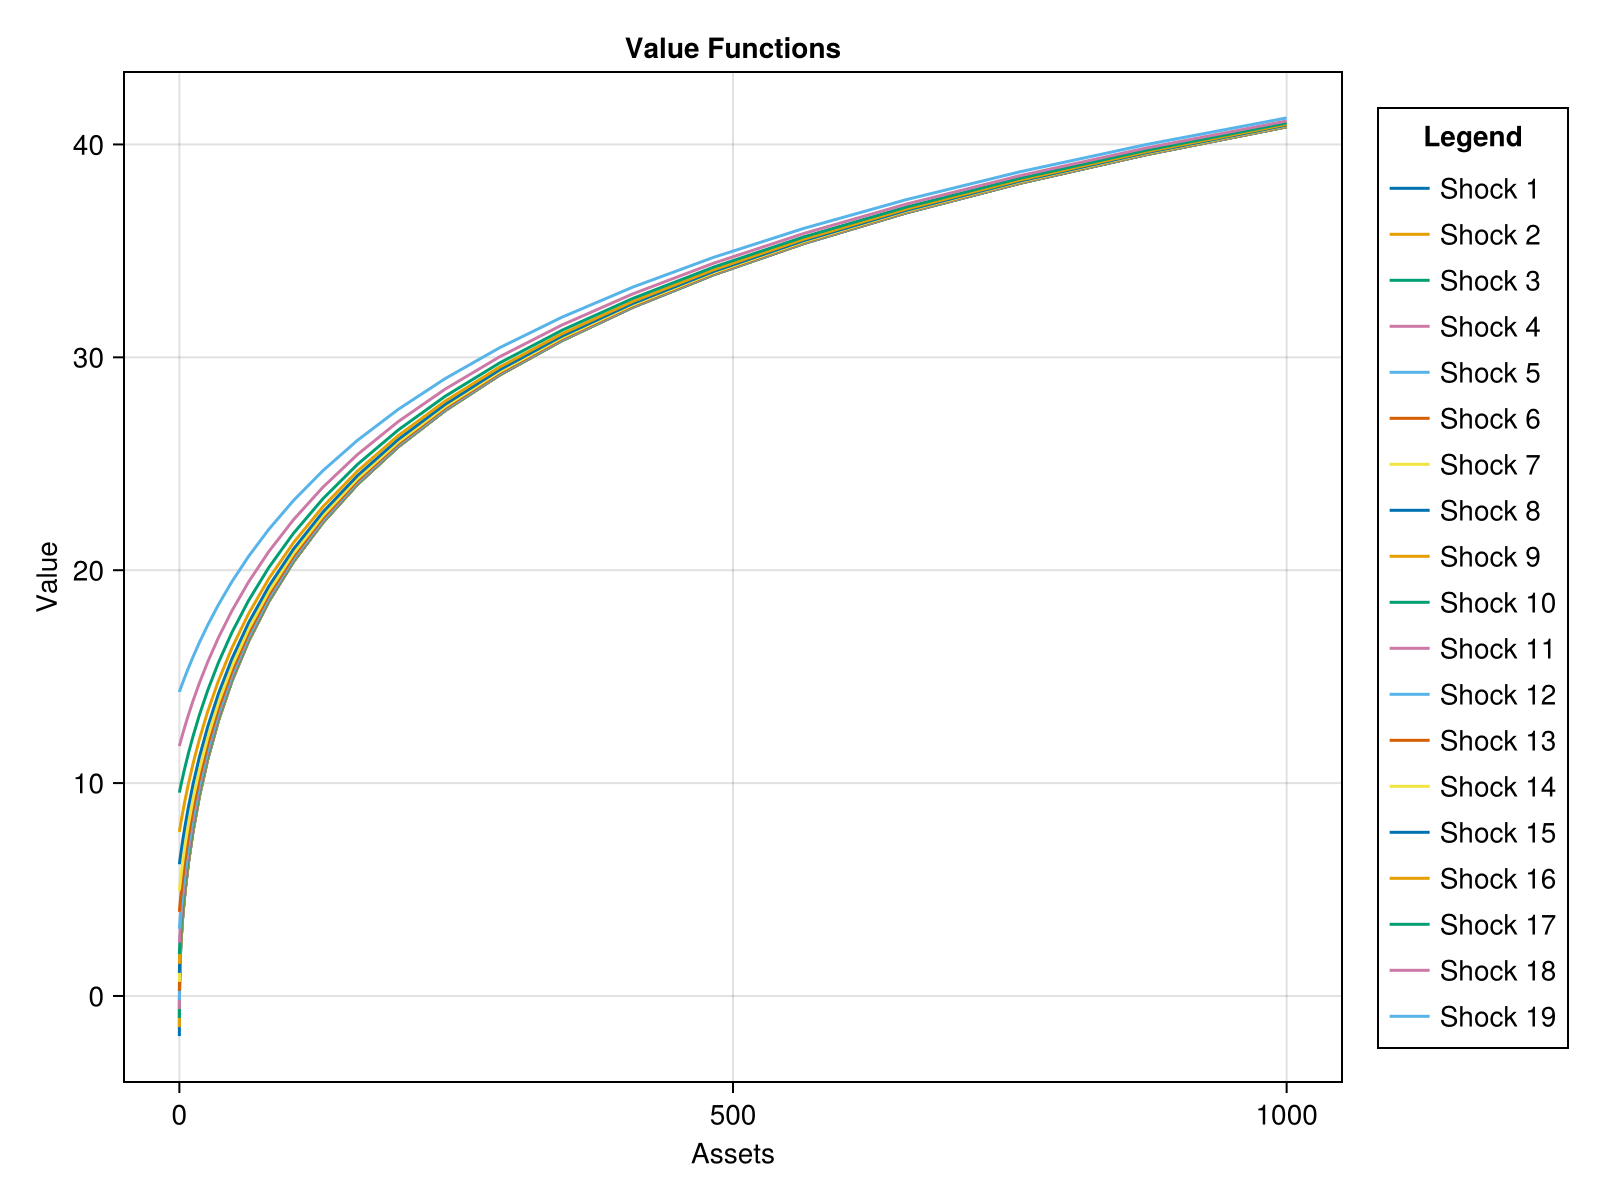

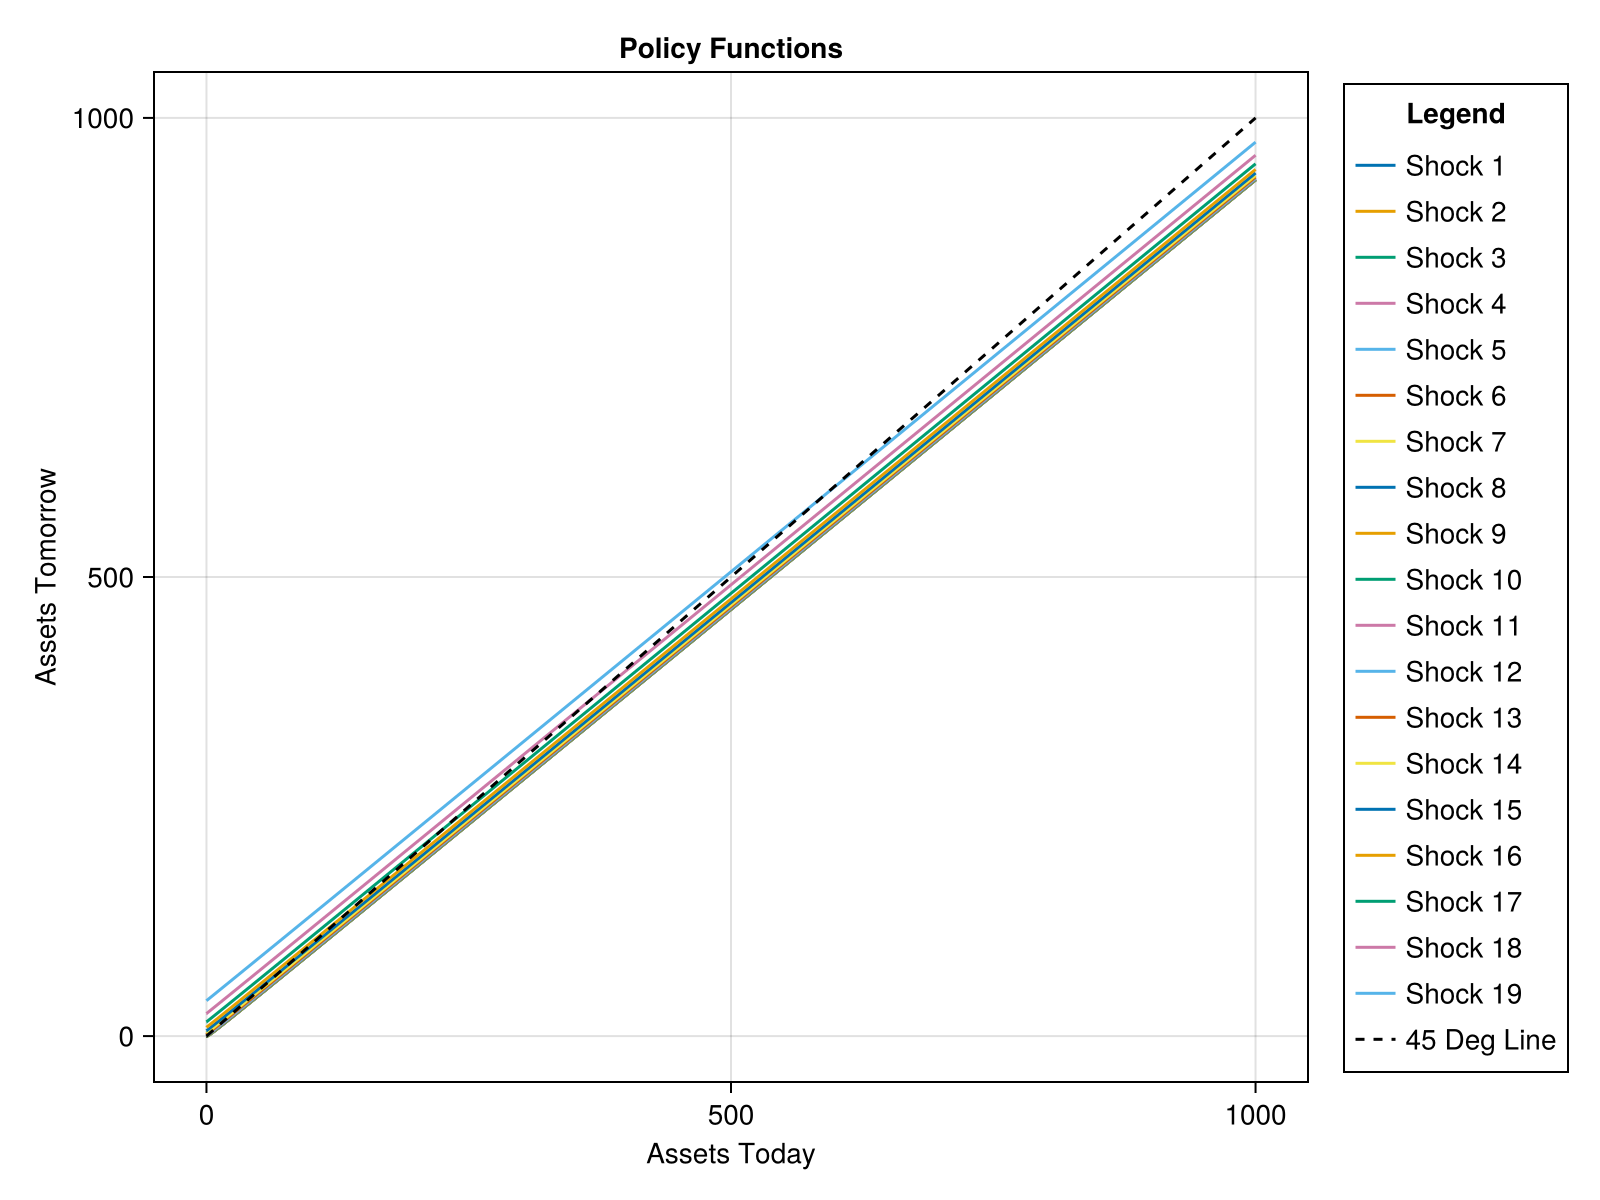

([-1.8846180380150233 -1.460353969303088 … 11.744219483227358 14.287074602485164; -1.8279698190462024 -1.4229310077678607 … 11.744459077784782 14.287254703882882; … ; 39.52244154410442 39.52256504888792 … 39.83420566830519 39.99518274961265; 40.83089490484234 40.83100310683649 … 41.10464785436407 41.24651626002306], [3.5181593885267114e-16 3.200489815799136e-16 … 24.518931925370627 38.5380587931216; 3.7533644879644497e-16 3.4072010392629244e-16 … 24.520067716425874 38.53920136296543; … ; 813.8747287478649 813.8851951061179 … 840.7068101209055 854.8924116112654; 932.4295916492978 932.4400760948752 … 959.3457146367507 973.6079963785296])

In [41]:
function vfi(v_init, pars)
    (; maxiter, toler, nz, na) = pars
    Π, Zvals = ar1(pars)
    Avals = exp_grid(pars)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v_new, policy = optimise(Avals, Zvals, v_init, v_new, policy, Π, pars)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % 10 == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    colors = [:red, :green, :blue, :orange, :purple, :cyan, :magenta, :yellow, :black, :gray]

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:pars.nz
        lines!(ax1, Avals, v_new[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:pars.nz
        lines!(ax2, Avals, policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Avals, Avals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return v_new, policy

end

v_init = ones(pars.na, pars.nz)

@time begin
v_out, pol_out = vfi(v_init, pars)
end